In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from networkx.algorithms.community import greedy_modularity_communities
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
import joblib

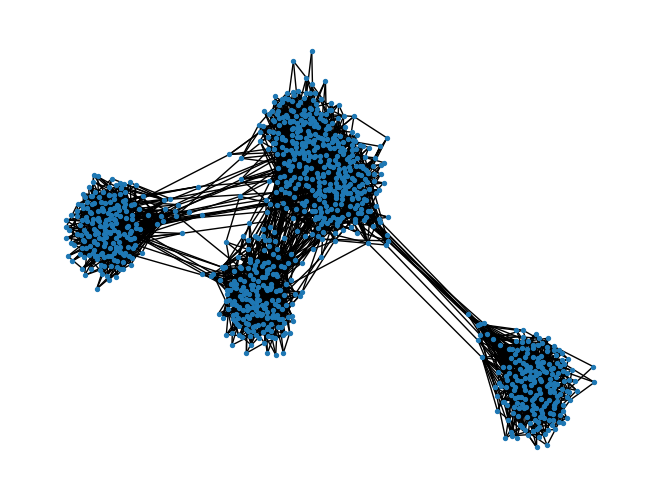

In [2]:
# We will start by importing network from an edgelist
G = nx.read_edgelist("edges_train.edgelist", data=False, nodetype = int, delimiter=',') # import
# Lets displace nodes following a Directed Force algorithm (remember Lecture 4, on Data Viz, and Lab 2 Aux)
pos = nx.spring_layout(G)
# Draw the graph
nx.draw(G, pos=pos, node_size=8)

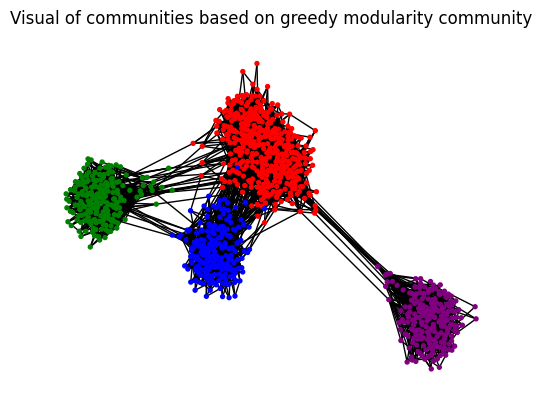

In [3]:
# Visualizing the clusters in the graph

#the function will return a partition of nodes
c = list(greedy_modularity_communities(G, resolution=0.8))

colors = {}
for node in G.nodes():
  if node in sorted(c[0]):
    colors[node] = 'red'
  elif node in sorted(c[1]):
    colors[node] = 'blue'
  elif node in sorted(c[2]):
    colors[node] = 'green'
  elif node in sorted(c[3]):
    colors[node] = 'purple'

plt.figure()
plt.title("Visual of communities based on greedy modularity community")
nx.draw(G,pos=pos, node_color=[colors[node] for node in G.nodes()], node_size=8)
plt.show()

The network has  1000  nodes
The network has  4368  edges


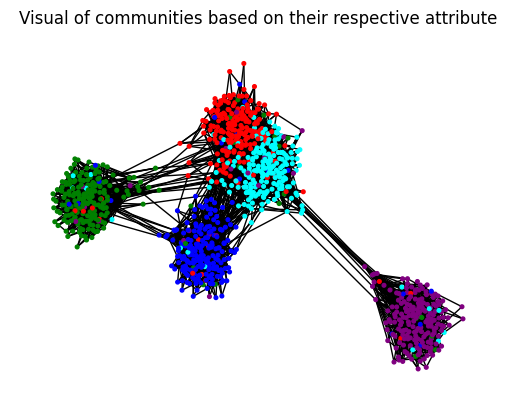

In [4]:
# Visualizing the clusters in the graph
attributes = pd.read_csv('attributes.csv')

# Sample data mapping attributes to colors
attribute_to_color = {
    'c': 'red',
    'd': 'cyan',
    'e': 'blue',
    'f': 'green',
    'g': 'purple'
}

# Add nodes to the graph and assign attributes
for _, row in attributes.iterrows():
    node_id = row['ID']
    attribute = row['attribute']
    G.add_node(node_id, attribute=attribute)

# Create a list of colors for nodes based on their attributes
node_colors = [attribute_to_color[G.nodes[node]['attribute']] for node in G.nodes]

#Compute number of nodes in the network
N = len(list(G.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(G.edges))
print("The network has ", E, " edges")

# Draw the graph with node colors
plt.figure()
plt.title("Visual of communities based on their respective attribute")
nx.draw(G,pos=pos, node_color=node_colors, node_size=7)
plt.show()

The network has  1000  nodes
The network has  3931  edges


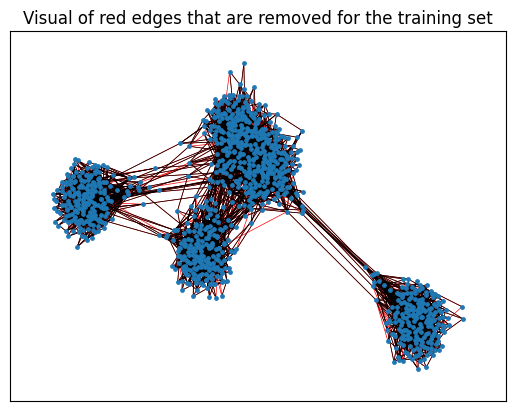

In [5]:
# We will now create a training set by removing nEdgesRemove random edges from the network above
# Removing 10 percent of the edges (which is 437 rounded)
nEdgesRemove = round(len(G.edges) * 0.1)

# Sample random edges
allEdges = np.array(G.edges)
np.random.seed(seed=42)
selectEdges = np.random.choice(np.arange(allEdges.shape[0]), nEdgesRemove, replace=False)
edgesToRemove = allEdges[selectEdges]

# Create new graph (H) without selected edges
H = G.copy()
H.remove_edges_from(edgesToRemove)

# Visualize the links that were removed (in red)
# Use the same colors as defined above to color communities
for i in range(len(c)):
    nx.draw_networkx_nodes(G, pos, nodelist=sorted(c[i]),node_size=6)

nx.draw_networkx_edges(G, pos, edge_color='red',width=0.5)
nx.draw_networkx_edges(H, pos, edge_color='black',width=0.5)

#Compute number of nodes in the network
N = len(list(H.nodes))
print("The network has ", N, " nodes")

#Compute number of edges in the network
E = len(list(H.edges))
print("The network has ", E, " edges")

plt.title("Visual of red edges that are removed for the training set")
plt.show()

In [6]:
def run_cv(model, X, y, cv):
    f1_scores = []

    for train, val in cv.split(X, y):
        X_train_fold, X_val_fold = [X[i] for i in train], [X[i] for i in val]
        y_train_fold, y_val_fold = [y[i] for i in train], [y[i] for i in val]
        model.fit(X_train_fold, y_train_fold)
        y_pred_val_fold = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred_val_fold))

    average_f1_score = np.mean(f1_scores)
    return average_f1_score

In [7]:
np.random.seed(42)

grid_values_logistic_regression = {'C':[0.001,.009,0.01,.09,1,5,10,25]}
param_grid = {
    'max_depth': [1, 3, 5, 7, 10],
    'min_samples_split': [5, 10, 15, 20, 50],
    'min_samples_leaf':[1, 3, 5, 7, 10]
    }
link_prediction_models = {
    'within_inter_cluster': nx.within_inter_cluster,
    'ra_index_soundarajan_hopcroft': nx.ra_index_soundarajan_hopcroft,
    'resource_allocation_index': nx.resource_allocation_index,
    'preferential_attachment': nx.preferential_attachment,
    'jaccard_coefficient': nx.jaccard_coefficient,
    'cn_soundarajan_hopcroft': nx.cn_soundarajan_hopcroft,
}

In [8]:
def modeling(model_list):

    L = H.copy()

    for node in L.nodes():
      L.nodes[node]["community"] = attributes.attribute[node]

    #fig, ax = plt.subplots()

    def getFeature(G, i, j):
        return[
            pa[i,j]]

    for model_name in model_list:
        pa = np.zeros((N,N))

        if model_name in link_prediction_models:
            preds = list(link_prediction_models[model_name](L, [(i,j) for i in range(N) for j in range(N)]))

        for u, v, p in preds:
          pa[u,v] = p

        # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
        X = []
        Y = []

        # Add positive examples where edge exist
        for (i, j) in H.edges:
            X.append(getFeature(H, i, j))
            Y.append(1)

        # Add negative examples where edge does not exist
        # We decided to take three times the amount of existing edges
        # 3931 * 3 = 11793
        for kk in range(11793):
                i = np.random.randint(N)
                j = np.random.randint(N)

                while H.has_edge(i,j) or i == j:
                    i = np.random.randint(N)
                    j = np.random.randint(N)

                X.append(getFeature(H, i, j))
                Y.append(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42,stratify=Y)
     
        # Fit
        clf = LogisticRegression(random_state=42)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        init_average_a = run_cv(clf, X_train, y_train, cv)
        print("Average F1 before hyperparameter tuning: ", init_average_a)

        grid_search = GridSearchCV(clf, grid_values_logistic_regression, cv=cv, scoring='f1')
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_clf = LogisticRegression(**best_params,random_state=42)
        after_average_a = run_cv(best_clf, X_train, y_train, cv)
        print("Average F1 after hyperparameter tuning: ", after_average_a)


# Call the modeling function with a list of model names
modeling(['within_inter_cluster', 'ra_index_soundarajan_hopcroft', \
          'resource_allocation_index', 'preferential_attachment', \
          'jaccard_coefficient', 'cn_soundarajan_hopcroft'])

Average F1 before hyperparameter tuning:  0.3887748277230691
Average F1 after hyperparameter tuning:  0.3887748277230691
Average F1 before hyperparameter tuning:  0.20174031336952686
Average F1 after hyperparameter tuning:  0.27370408090338155
Average F1 before hyperparameter tuning:  0.30753321466372135
Average F1 after hyperparameter tuning:  0.37942336475119276
Average F1 before hyperparameter tuning:  0.271280174949473
Average F1 after hyperparameter tuning:  0.271280174949473
Average F1 before hyperparameter tuning:  0.029155050969136575
Average F1 after hyperparameter tuning:  0.25683449569162936
Average F1 before hyperparameter tuning:  0.5069277327233818
Average F1 after hyperparameter tuning:  0.5069277327233818


In [9]:
# Define a dictionary mapping model names to NetworkX functions
def modeling(model_list):

    L = H.copy()

    for node in L.nodes():
      L.nodes[node]["community"] = attributes.attribute[node]

    #fig, ax = plt.subplots()

    def getFeature(G, i, j):
        return[
            pa[i,j]]

    for model_name in model_list:
        pa = np.zeros((N,N))

        if model_name in link_prediction_models:
            preds = list(link_prediction_models[model_name](L, [(i,j) for i in range(N) for j in range(N)]))

        for u, v, p in preds:
          pa[u,v] = p

        # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
        X = []
        Y = []

        # Add positive examples where edge exist
        for (i, j) in H.edges:
            X.append(getFeature(H, i, j))
            Y.append(1)

        # Add negative examples where edge does not exist
        # We decided to take three times the amount of existing edges
        # 3931 * 3 = 11793
        for kk in range(11793):
                i = np.random.randint(N)
                j = np.random.randint(N)

                while H.has_edge(i,j) or i == j:
                    i = np.random.randint(N)
                    j = np.random.randint(N)

                X.append(getFeature(H, i, j))
                Y.append(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42,stratify=Y)
  
        # Fit
        my_dt = tree.DecisionTreeClassifier(random_state=42)
        # clf = RandomForestClassifier(max_depth= 3, min_samples_leaf= 7, min_samples_split= 50)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        init_average_a = run_cv(my_dt, X_train, y_train, cv)
        print("Average F1 before hyperparameter tuning: ", init_average_a)

        grid_search = GridSearchCV(my_dt, param_grid, cv=cv, scoring='f1')
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        best_clf = tree.DecisionTreeClassifier(**best_params,random_state=42)
        print("Best parameters"+ str(best_params))
        after_average_a = run_cv(best_clf, X_train, y_train, cv)
        print("Average F1 after hyperparameter tuning: ", after_average_a)


# Call the modeling function with a list of model names
modeling(['within_inter_cluster', 'ra_index_soundarajan_hopcroft', \
          'resource_allocation_index', 'preferential_attachment', \
          'jaccard_coefficient', 'cn_soundarajan_hopcroft'])

Average F1 before hyperparameter tuning:  0.4501348058981699
Best parameters{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average F1 after hyperparameter tuning:  0.4501348058981699
Average F1 before hyperparameter tuning:  0.39335292217807505
Best parameters{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average F1 after hyperparameter tuning:  0.45338616413435295
Average F1 before hyperparameter tuning:  0.4702884982332395
Best parameters{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average F1 after hyperparameter tuning:  0.5745965661490036
Average F1 before hyperparameter tuning:  0.29955338609540927
Best parameters{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average F1 after hyperparameter tuning:  0.444252335802208
Average F1 before hyperparameter tuning:  0.49005856704988043
Best parameters{'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 5}
Average F1 after hyperparameter tuning:  0.56826928022250

In [ ]:
# Define a dictionary mapping model names to NetworkX functions
param_grid ={'max_depth':[1, 3, 5, 7, 10],
              'max_features':[1,3,5,7],
              'min_samples_leaf':[1, 3, 5, 7, 10],
              'min_samples_split':[5, 10, 15, 20, 50]
           }

def modeling(model_list):

    L = H.copy()

    for node in L.nodes():
      L.nodes[node]["community"] = attributes.attribute[node]

    #fig, ax = plt.subplots()

    def getFeature(G, i, j):
        return[
            pa[i,j]]

    for model_name in model_list:
        pa = np.zeros((N,N))

        if model_name in link_prediction_models:
            preds = list(link_prediction_models[model_name](L, [(i,j) for i in range(N) for j in range(N)]))

        for u, v, p in preds:
          pa[u,v] = p

        # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
        X = []
        Y = []

        # Add positive examples where edge exist
        for (i, j) in H.edges:
            X.append(getFeature(H, i, j))
            Y.append(1)

        # Add negative examples where edge does not exist
        # We decided to take three times the amount of existing edges
        # 3931 * 3 = 11793
        for kk in range(11793):
                i = np.random.randint(N)
                j = np.random.randint(N)

                while H.has_edge(i,j) or i == j:
                    i = np.random.randint(N)
                    j = np.random.randint(N)

                X.append(getFeature(H, i, j))
                Y.append(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42,stratify=Y)
        # Fit
        my_dt = RandomForestClassifier(random_state=42)
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
        init_average_a = run_cv(my_dt, X_train, y_train, cv)
        print("Average F1 before hyperparameter tuning: ", init_average_a)

        grid_search = GridSearchCV(my_dt, param_grid, cv=cv, scoring='f1')
        grid_search.fit(X_train, y_train)

        best_params = grid_search.best_params_
        print("Best parameters"+ str(best_params))
        best_clf = RandomForestClassifier(**best_params,random_state=42)
        after_average_a = run_cv(best_clf, X_train, y_train, cv)
        print("Average F1 after hyperparameter tuning: ", after_average_a)

# Call the modeling function with a list of model names
modeling(['within_inter_cluster', 'ra_index_soundarajan_hopcroft', \
          'resource_allocation_index', 'preferential_attachment', \
          'jaccard_coefficient', 'cn_soundarajan_hopcroft'])

In [10]:
# Define a dictionary mapping model names to NetworkX functions
def modeling(model_list):

    L = H.copy()

    for node in L.nodes():
      L.nodes[node]["community"] = attributes.attribute[node]

    #fig, ax = plt.subplots()

    def getFeature(G, i, j):
        return[
            pa[i,j]]

    for model_name in model_list:
        pa = np.zeros((N,N))

        if model_name in link_prediction_models:
            preds = list(link_prediction_models[model_name](L, [(i,j) for i in range(N) for j in range(N)]))

        for u, v, p in preds:
          pa[u,v] = p

        # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
        X = []
        Y = []

        # Add positive examples where edge exist
        for (i, j) in H.edges:
            X.append(getFeature(H, i, j))
            Y.append(1)

        # Add negative examples where edge does not exist
        # We decided to take three times the amount of existing edges
        # 3931 * 3 = 11793
        for kk in range(11793):
                i = np.random.randint(N)
                j = np.random.randint(N)

                while H.has_edge(i,j) or i == j:
                    i = np.random.randint(N)
                    j = np.random.randint(N)

                X.append(getFeature(H, i, j))
                Y.append(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42,stratify=Y)
        # Fit
        best_clf = tree.DecisionTreeClassifier(max_depth=1,min_samples_leaf=1,min_samples_split=5,random_state=42)
        best_clf.fit(X_train,y_train)


        y_pred_class = best_clf.predict(X_test)
        y_pred_prob = best_clf.predict_proba(X_test)[:,1]
        tr_test_accuracy_score = accuracy_score(y_test,  y_pred_class)
        print("Accuracy on Test:", tr_test_accuracy_score)
        tr_roc_auc_result = roc_auc_score(y_test, y_pred_prob)
        print("AUC", tr_roc_auc_result)

# Call the modeling function with a list of model names
modeling(['cn_soundarajan_hopcroft'])

Accuracy on Test: 0.8290143084260732
AUC 0.7338102808691043


In [31]:
# Define a dictionary mapping model names to NetworkX functions
link_prediction_models = {
    'cn_soundarajan_hopcroft': nx.cn_soundarajan_hopcroft,
}

def modeling(model_list):

    L = H.copy()

    for node in L.nodes():
      L.nodes[node]["community"] = attributes.attribute[node]

    #fig, ax = plt.subplots()

    def getFeature(G, i, j):
        return[
            pa[i,j]]

    for model_name in model_list:
        pa = np.zeros((N,N))

        if model_name in link_prediction_models:
            preds = list(link_prediction_models[model_name](L, [(i,j) for i in range(N) for j in range(N)]))

        for u, v, p in preds:
          pa[u,v] = p

        # Let us now create a training set where X will correspond to features for each possible edge and Y the predciton
        X = []
        Y = []

        # Add positive examples where edge exist
        for (i, j) in H.edges:
            X.append(getFeature(H, i, j))
            Y.append(1)

        # Add negative examples where edge does not exist
        # We decided to take three times the amount of existing edges
        # 3931 * 3 = 11793
        for kk in range(11793):
                i = np.random.randint(N)
                j = np.random.randint(N)

                while H.has_edge(i,j) or i == j:
                    i = np.random.randint(N)
                    j = np.random.randint(N)

                X.append(getFeature(H, i, j))
                Y.append(0)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.8, random_state = 42,stratify=Y)
        # Fit
        best_clf = tree.DecisionTreeClassifier(max_depth=1,min_samples_leaf=1,min_samples_split=5,random_state=42)
        best_clf.fit(X_train,y_train)

        inpTest = pd.read_csv('solutionInput.csv', sep=',', index_col="ID")
        inpTest = np.array(inpTest)
        inp = []

        for i in inpTest:
            inp.append(getFeature(H, i[0], i[1]))

        # Predict
        predictionsLR = best_clf.predict(inp)

        # Transform and show
        df = pd.DataFrame({'ID': range(len(predictionsLR)), 'prediction': predictionsLR})
        df.head()

        # Export Final DF
        #df.to_csv('prediction_v10.csv', index=False)
        #joblib.dump(best_clf, 'link_prediction.pkl')

# Call the modeling function with a list of model names
modeling(['cn_soundarajan_hopcroft'])

In [11]:
model = joblib.load('link_prediction.pkl') 